# Comparing tides with currents and winds

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import xarray as xr
import pickle
import time
import datetime
from scipy.signal import butter, lfilter
%matplotlib inline

## Create Variables

In [24]:
ssh = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSgSurfaceTracerFields1hV18-06")

In [25]:
times_ssh = ssh.time.sel(time = ssh.time.dt.year.isin([2015,2016,2017,2018])).values.astype('datetime64[D]').astype(datetime.datetime)

In [26]:
data = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSgNearSurfaceUVelocity20mV18-06")

In [27]:
times_current = data.time.sel(time = data.time.dt.year.isin([2015,2016,2017,2018])).values.astype('datetime64[s]').astype(datetime.datetime)

In [28]:
winddata = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1")
wind_times = winddata.time.values.astype('datetime64[s]').astype(datetime.datetime)

#### Current Variables

In [29]:
for year in [2015, 2016, 2017, 2018]:
    fname = "/home/abhudia/Desktop/current speed/3points20m/current_sog{}.pickle".format(str(year))
    file = open(fname, "rb")
    locals()["current_sog" + str(year)] = pickle.load(file)
    locals()["t_sog" + str(year)] = []
    for time in times_current: 
        if time.year == year:
            locals()["t_sog" + str(year)].append(time)

In [30]:
for year in [2015, 2016, 2017, 2018]:
    fname = "/home/abhudia/Desktop/current speed/3points20m/current_salmon{}.pickle".format(str(year))
    file = open(fname, "rb")
    locals()["current_salmon" + str(year)] = pickle.load(file)
    locals()["t_salmon" + str(year)] = []
    for time in times_current: 
        if time.year == year:
            locals()["t_salmon" + str(year)].append(time)

In [31]:
for year in [2015, 2016, 2017, 2018]:
    fname = "/home/abhudia/Desktop/current speed/3points20m/current_turn{}.pickle".format(str(year))
    file = open(fname, "rb")
    locals()["current_turn" + str(year)] = pickle.load(file)
    locals()["t_turn" + str(year)] = []
    for time in times_current: 
        if time.year == year:
            locals()["t_turn" + str(year)].append(time)

#### SSH Variables

In [32]:
for year in [2015, 2016, 2017, 2018]:
    fname = "/home/abhudia/Desktop/SSH/3points/ssh_sog{}.pickle".format(str(year))
    file = open(fname, "rb")
    locals()["ssh_sog" + str(year)] = pickle.load(file)
    locals()["tssh_sog" + str(year)] = []
    for time in times_ssh: 
        if time.year == year:
            locals()["tssh_sog" + str(year)].append(time)

In [33]:
for year in [2015, 2016, 2017, 2018]:
    fname = "/home/abhudia/Desktop/SSH/3points/ssh_salmon{}.pickle".format(str(year))
    file = open(fname, "rb")
    locals()["ssh_salmon" + str(year)] = pickle.load(file)
    locals()["tssh_salmon" + str(year)] = []
    for time in times_ssh: 
        if time.year == year:
            locals()["tssh_salmon" + str(year)].append(time)

In [34]:
for year in [2015, 2016, 2017, 2018]:
    fname = "/home/abhudia/Desktop/SSH/3points/ssh_turn{}.pickle".format(str(year))
    file = open(fname, "rb")
    locals()["ssh_turn" + str(year)] = pickle.load(file)
    locals()["tssh_turn" + str(year)] = []
    for time in times_ssh: 
        if time.year == year:
            locals()["tssh_turn" + str(year)].append(time)

#### Wind Variables

In [35]:
years = [2015,2016,2017,2018]
abbrs = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'july', 'aug', 'sept', 'oct' ,'nov' ,'dec']
locs = ['salmon' ,'turn', 'sog']
for year in [2015, 2016, 2017, 2018]:
    for loc in locs:
        fname = "/home/abhudia/Desktop/Wind speed/3points/winds_{}{}.pickle".format(loc, str(year))
        file = open(fname, "rb") 
        locals()["winds_{}".format(loc) + str(year)] = pickle.load(file)
        locals()["twind_{}".format(loc) + str(year)] = []
        for time in wind_times: 
            if time.year == year:
                locals()["twind_{}".format(loc) + str(year)].append(time)

#### Salinity Variables

In [36]:
salinity = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-06")
times_salinity = salinity.time.sel(time = salinity.time.dt.year.isin([2015,2016,2017,2018])).values.astype('datetime64[s]').astype(datetime.datetime)

In [83]:
locs = ['sog', 'salmon', 'turn']
for loc in locs:
    for year in [2015, 2016, 2017, 2018]:
        fname = "/home/abhudia/Desktop/salinity/3points/{}{}.pickle".format(loc, str(year))
        file = open(fname, "rb")
        locals()[loc + "sal" + str(year)] = pickle.load(file)
        locals()["tsal" + str(year)] = []
        for time in times_salinity: 
            if time.year == year:
                locals()["tsal" + str(year)].append(time)  

### Function Definitions

In [38]:
## Array List/Array -> Listof(Array, Array)
## produce a list where first element is listof Days and second element is listof (Max-Min ssh)
def ssh_amplitudes(ssh_array, times):
    # Returns only one copy of each day, and count of times each day appears
    unique, counts = np.unique(times, return_counts=True) 
    mins = []; maxes = []
    index = 0
    
    # for the numbers of hours in a day, determine the min and max ssh that day
    for count in counts:
        initial = ssh_array[index]
        day_min = initial; day_max = initial
      
        while count != 0:
            ssh = ssh_array[index]
            if ssh < day_min:
                day_min = ssh
            if ssh > day_max:
                day_max = ssh
            index = index + 1
            count = count - 1
            
        # add these values to the lists of max and min ssh    
        mins.append(day_min); maxes.append(day_max)
    
    return([unique, np.asarray(maxes)-np.asarray(mins)])   


In [39]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [40]:
def average_output(data_array, times, period):

    unique, counts = np.unique(np.asarray(times).astype('datetime64[{}]'.format(period)).astype(datetime.datetime), return_counts=True) 
    index = 0; count_so_far = 0; means = []
    
    for count in counts:
        means.append(np.sum(data_array[count_so_far: count_so_far + count])/count)
        count_so_far = count_so_far + count
        
    return([unique, means])  

## Create Plots

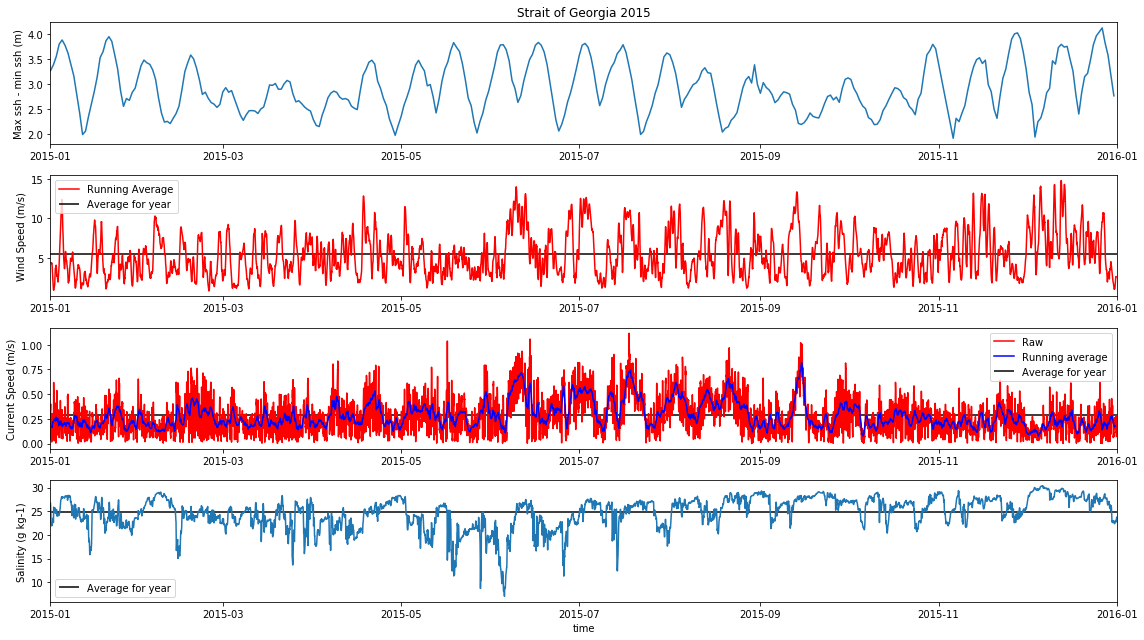

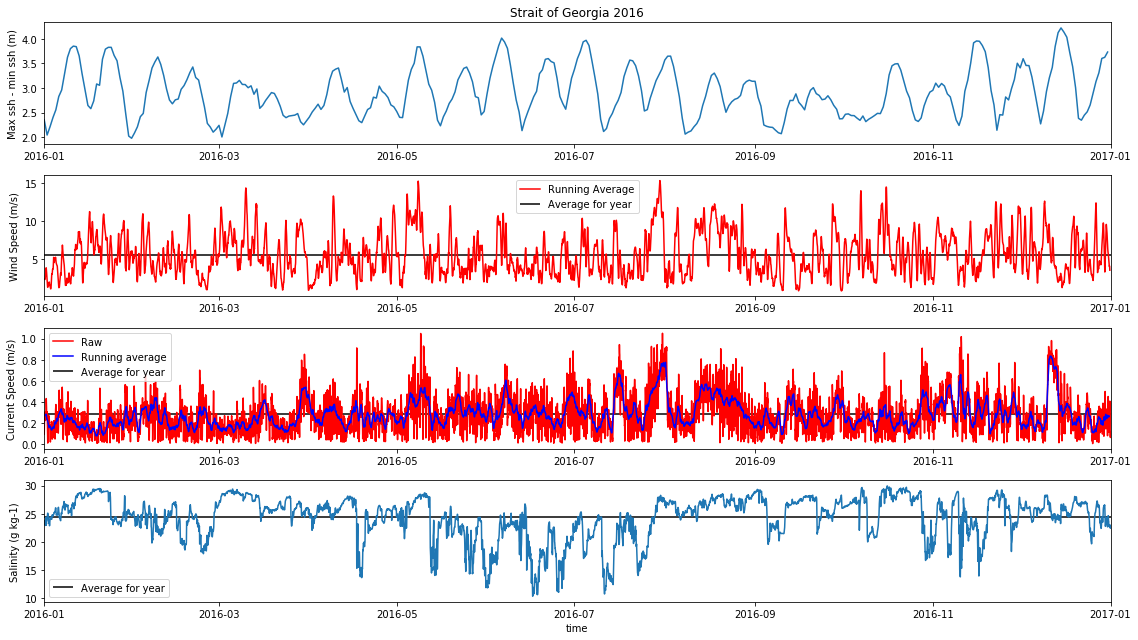

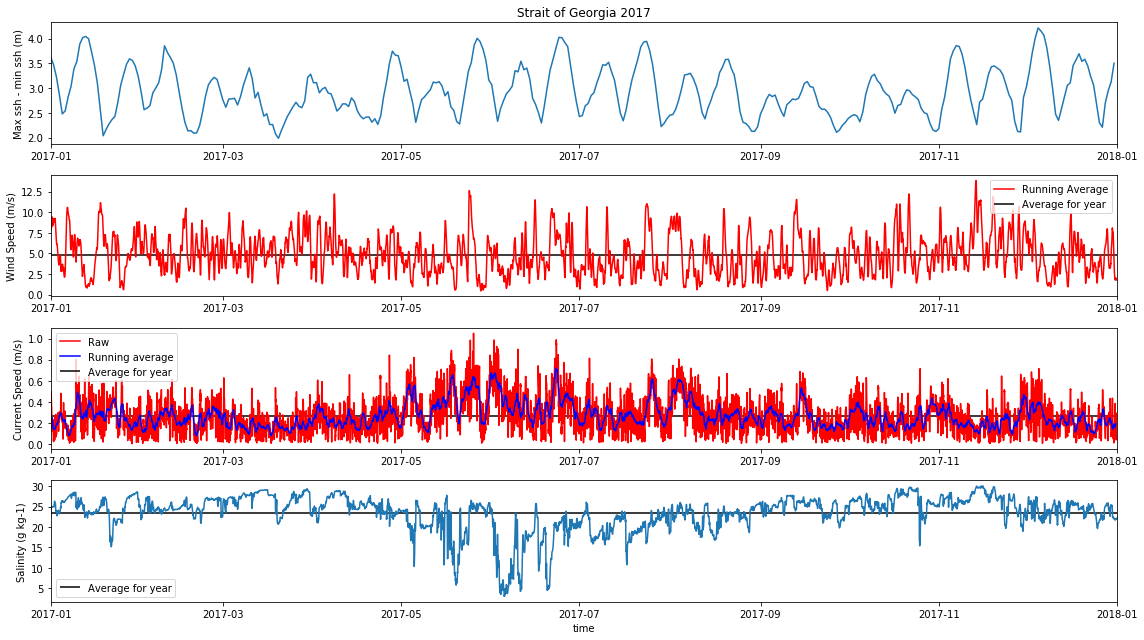

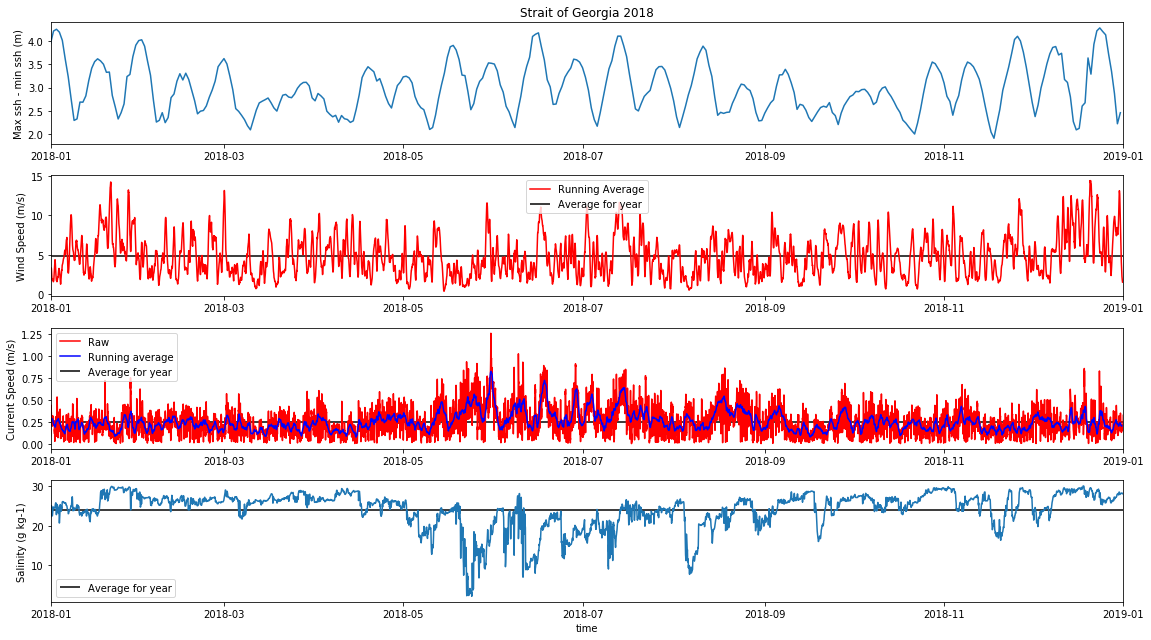

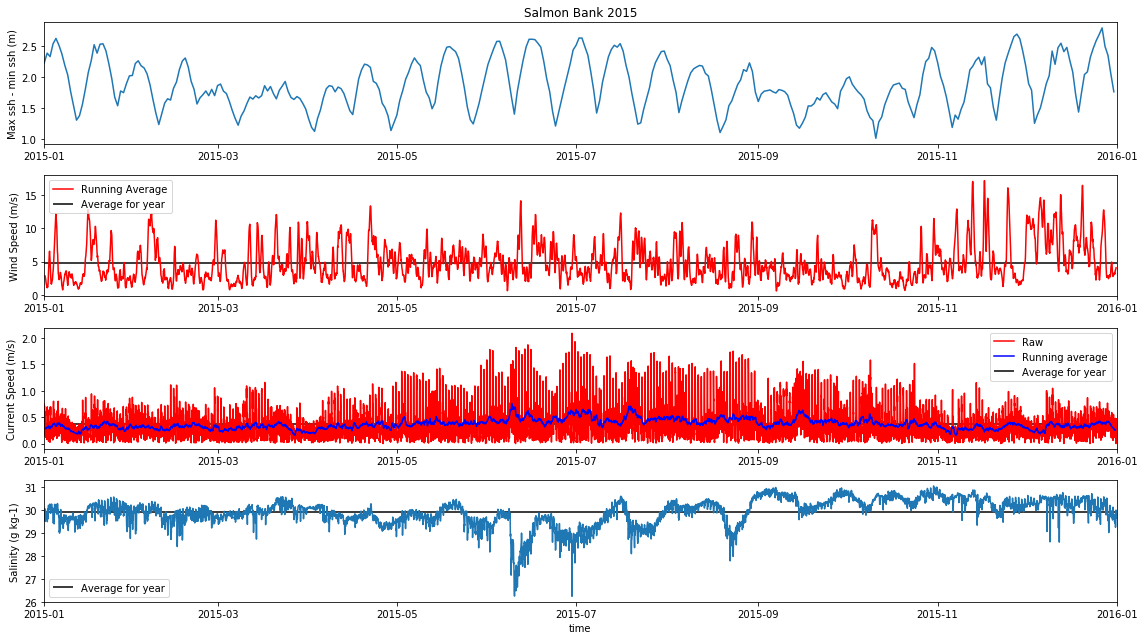

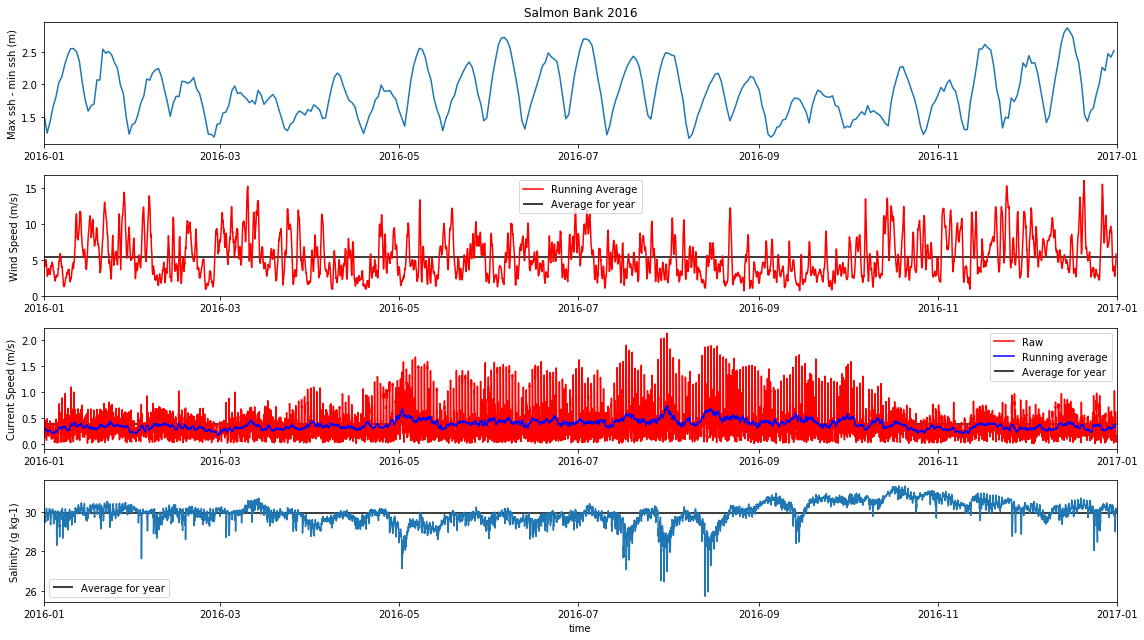

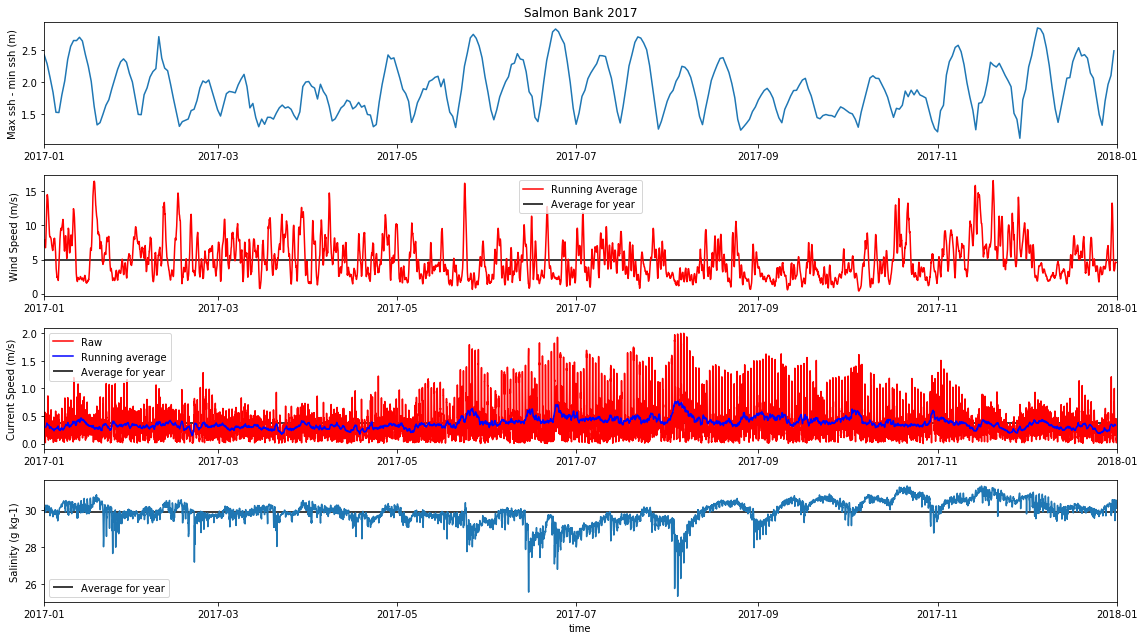

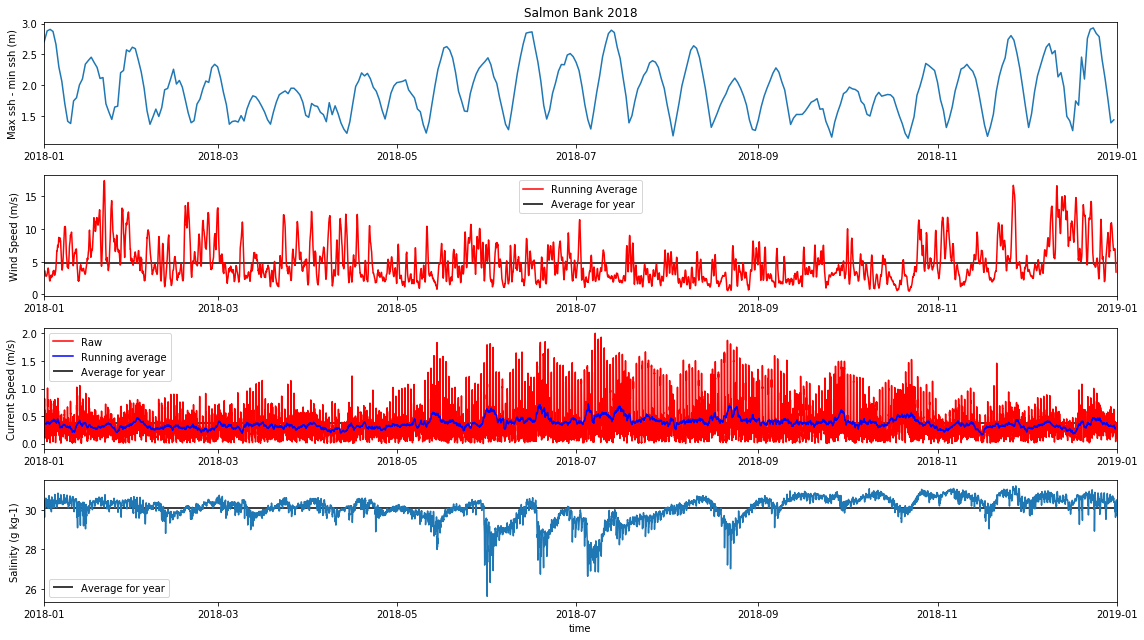

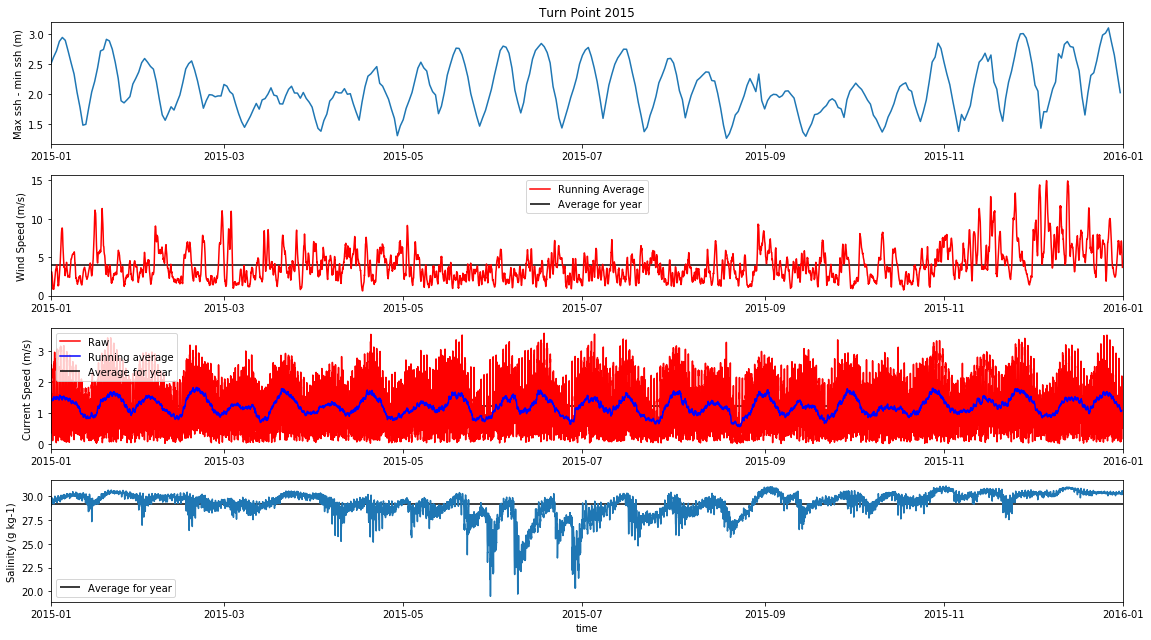

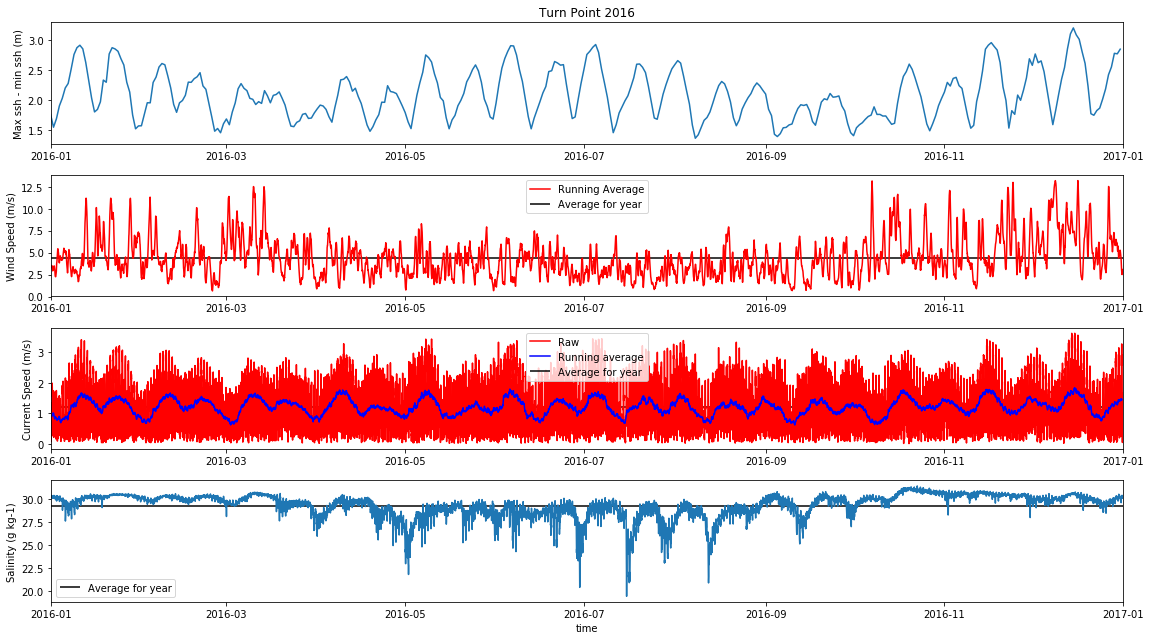

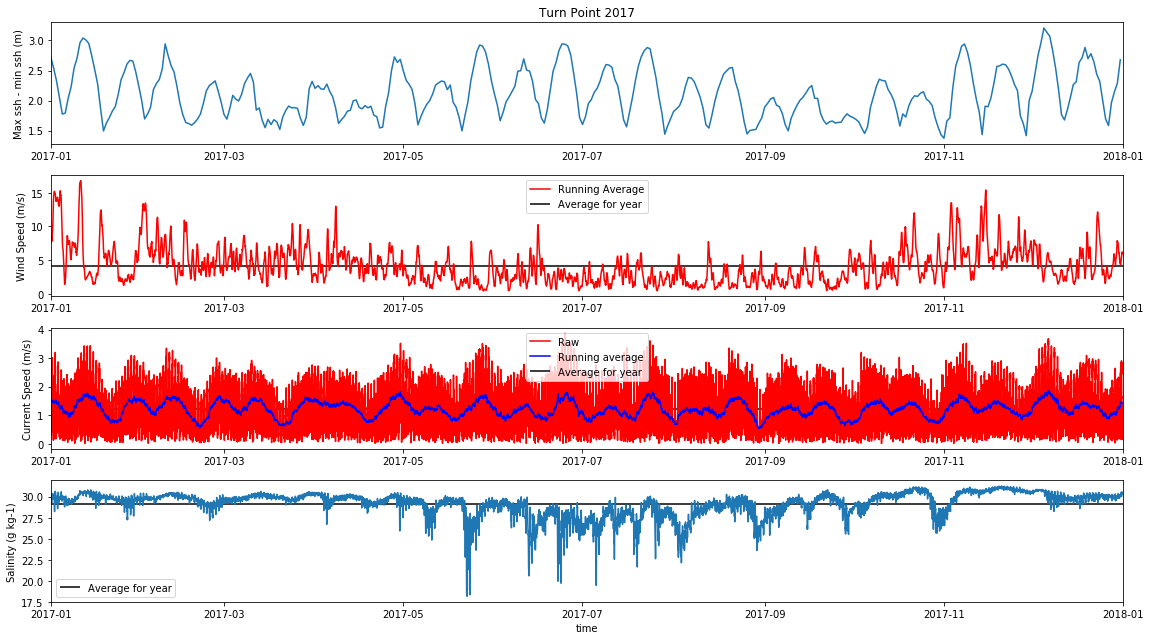

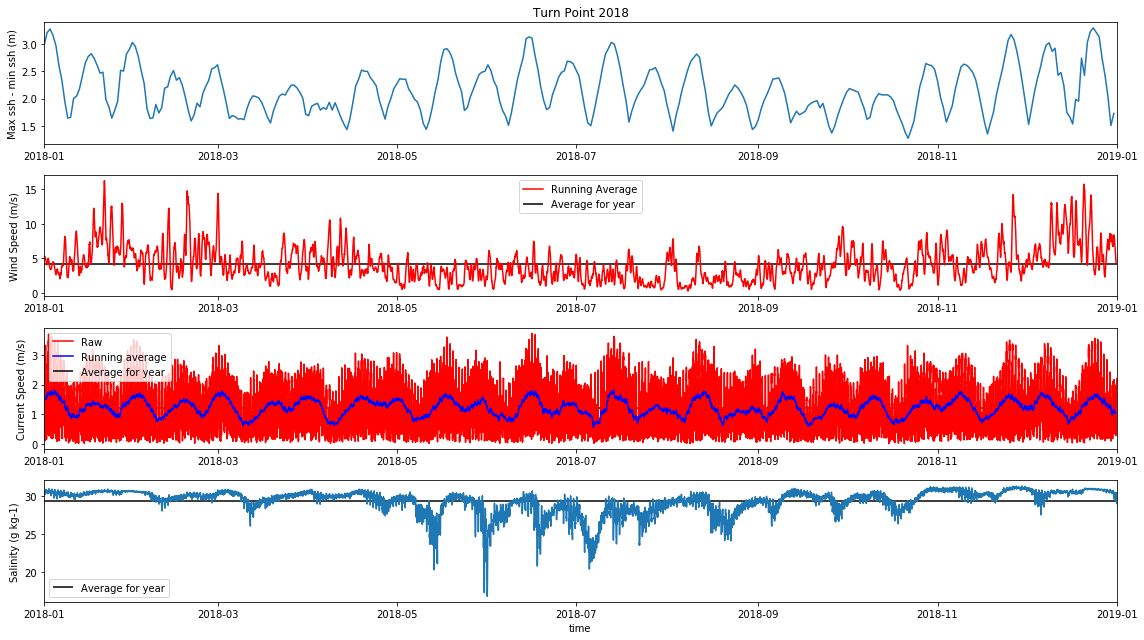

In [86]:
locs = ['sog', 'salmon', 'turn']
locations = ['Strait of Georgia', 'Salmon Bank', 'Turn Point']
years = [2015, 2016, 2017, 2018]
N = 72
M = 12
for index in range(3):
    for year in years:
        current = locals()['current_{}{}'.format(locs[index], str(year))]
        times = []
        for time in times_current: 
            if time.year == year:
                times.append(time)
        fig = plt.figure(figsize=(16,9))
        
        ax1 = plt.subplot(4,1,1)
        ssh_array = "ssh_{}{}".format(locs[index], str(year))
        times = "tssh_{}{}".format(locs[index], str(year))
        data = ssh_amplitudes(locals()[ssh_array], locals()[times])
        neap = np.argmin(data[1]); spring = np.argmax(data[1])
        #label = "The highest spring was on {} ({} m) and the lowest neap was on {} ({} m)".format(str(data[0][spring]), data[1][spring], str(data[0][neap]), data[1][neap])
        plt.plot(data[0], data[1], label = label)
        ax1.set_xlim([datetime.datetime(year, 1 , 1), datetime.datetime(year+1, 1 , 1)])
        # plt.xlabel('time')
        plt.ylabel('Max ssh - min ssh (m)')
        #######title = '{} {}'.format(locations[index], year)
        title = 'max - min ssh at {} in {} (m)'.format(locations[index], year)
        plt.title(title)
        #plt.legend()
        
        ax2 = plt.subplot(4,1,2)
        wind_array = "winds_{}{}".format(locs[index], str(year))
        times = "twind_{}{}".format(locs[index], str(year))
        avg_values = running_mean(locals()[wind_array], M)
        avg_times = locals()[times][int(M/2): int(len(locals()[times]) - M/2 +1)]
        #plt.plot(locals()[times], locals()[wind_array],'b-' ,label = 'Raw')
        plt.hlines(np.mean(locals()[wind_array]), datetime.datetime(year, 1 , 1), datetime.datetime(year+1, 1 , 1), label = 'Average for year')
        plt.plot(avg_times, avg_values, 'r-', label = 'Running Average')
        ax2.set_xlim([datetime.datetime(year, 1 , 1), datetime.datetime(year+1, 1 , 1)])
       # plt.xlabel('time')
        plt.ylabel('Wind Speed (m/s)')
        plt.legend()
        title = 'Running average of Wind speed at {} in {} (m/s)'.format(locations[index], year)
        #plt.title(title)
        
    
        
        ax3 = plt.subplot(4,1,3)
        current = locals()['current_{}{}'.format(locs[index], str(year))]
        times = []
        for time in times_current: 
            if time.year == year:
                times.append(time)
        plt.plot(times, current, 'r-', label = 'Raw')
        #plt.xlabel('time')
        plt.ylabel('Current Speed (m/s)')
        title = 'Current speed at {} in {} (m/s)'.format(locations[index], year)
        avg_values = running_mean(current, N)
        avg_times = times[int(N/2): int(len(times) - N/2 +1)]
        plt.plot(avg_times, avg_values, 'b-', label = 'Running average')
        ax3.set_xlim([datetime.datetime(year, 1 , 1), datetime.datetime(year+1, 1 , 1)])
        plt.hlines(np.mean(current), datetime.datetime(year, 1 , 1), datetime.datetime(year+1, 1 , 1), label = 'Average for year', linestyles='solid')
        plt.legend()
        #plt.title(title)
        
        ax4 = plt.subplot(4,1,4)
        plt.xlabel('time')
        plt.ylabel('Salinity (g kg-1)')
        title = 'Salinity at {} point in {}'.format(locations[index],year)
        mean = np.mean(locals()[locs[index] + "sal" + str(year)])
        plt.hlines(mean, datetime.datetime(year, 1 , 1), datetime.datetime(year+1, 1 , 1), label = 'Average for year', linestyles='solid')
        plt.plot(locals()["tsal" + str(year)], locals()['{}sal{}'.format(locs[index], str(year))])
        ax4.set_xlim([datetime.datetime(year, 1 , 1), datetime.datetime(year+1, 1 , 1)])
        #plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.savefig('slides/{}{}.png'.format(locs[index],str(year)), dpi = 300)